# Ciclo 1: Health Insurance Cross-Sell

# Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import psycopg2
import pandas.io.sql as psql
import seaborn as sns
import scikitplot as skplt
import requests
import json
import random as rd
import matplotlib
import matplotlib.pyplot      as plt

import sklearn
from sklearn import model_selection as ms
from sklearn import ensemble as en

import sklearn.neighbors as nh
import sklearn.linear_model as lm


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Functions

In [2]:
def precision_at_k(data, k= 2000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k,'precision_at_k']

def recall_at_k(data, k= 2000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k,'recall_at_k']

def check_performance(results_list, x_validation, y_validation,num):
    list_precision = []
    list_recall = []
    df_precision = pd.DataFrame()
    df_recall = pd.DataFrame()
    n = 0
    for i in results_list:
        #print(i)
        df8 = x_validation.copy()
        df8['response'] = y_validation.copy()
        df8['score'] = i[:,1].tolist()
        df8 = df8[['id','response','score']].sort_values('score', ascending=False)
        
        list_precision.append(precision_at_k(df8,k=num))
        list_recall.append(recall_at_k(df8,k=num))
        
        #print(list_recall)
        
        #df_precision = pd.DataFrame(
        #            {
        #                list_precision
        #            }
        #)
    df_precision = df_precision.append(list_precision)
    df_recall = df_recall.append(list_recall)
    return df_precision, df_recall #list_precision, list_recall

def check_performance(results_list, x_validation, y_validation, num):
    list_precision = []
    list_recall = []
    
    df8 = x_validation.copy()
    df8['response'] = y_validation.copy()
    
    for result in results_list:
        df8['score'] = result[:, 1].tolist()
        df8_sorted = df8[['id', 'response', 'score']].sort_values('score', ascending=False)
        list_precision.append(precision_at_k(df8_sorted, k=num))
        list_recall.append(recall_at_k(df8_sorted, k=num))
    
    df_precision = pd.DataFrame({'precision': list_precision})
    df_recall = pd.DataFrame({'recall': list_recall})
    
    return [df_precision, df_recall]


# Data Load

In [3]:
#conn = psycopg2.connect(
#        host="comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com",
#        database="comunidadedsdb",
#        user="member",
#        password="cdspa"
#
#)
#
#cur = conn.cursor()
        
#query = "select * from pa004.users"
#
#cur.execute(query)
#dados = cur.fetchall()
#dados

In [4]:
df_raw = pd.read_csv( '../data/raw/train.csv' )

In [5]:
#query = """select users.id, gender, age, driving_license, region_code, previously_insured, vehicle_age, vehicle_damage,
#                annual_premium,
#                policy_sales_channel,
#                vintage,
#                response
#            from pa004.users
#                inner join pa004.insurance i on i.id = users.id
#                inner join pa004.vehicle v on v.id = users.id"""
#
#df = psql.read_sql(query, conn)
#df.head()

In [6]:
df_production = pd.read_csv('../data/raw/test.csv')

# 1.0 Descrição dos Dados

In [7]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [8]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

In [9]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.2 Dimensão dos Dados

In [10]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3 Tipo dos Dados

In [11]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check Na

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Análise Estatística

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [14]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 Feature Engineering

In [15]:
df2 = df1.copy()

In [16]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [17]:
# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0 EDA

In [18]:
df3 = df2.copy()

In [19]:
df3.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 3.1 Análise Univariada

<Axes: xlabel='response', ylabel='age'>

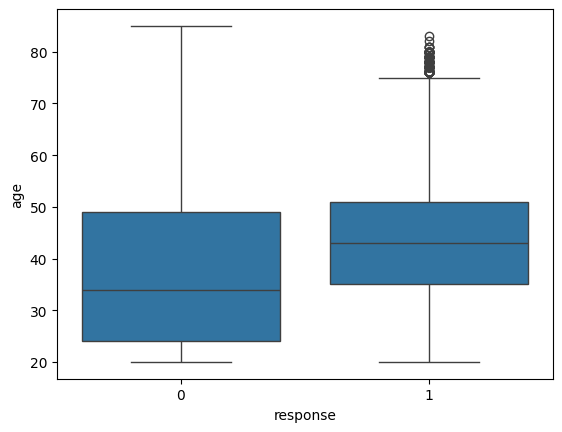

In [20]:
# age
sns.boxplot(x='response', y='age', data=df3)

<Axes: xlabel='age', ylabel='Count'>

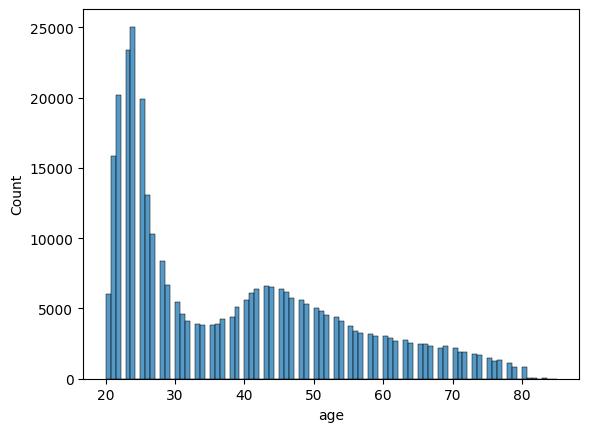

In [21]:
aux00 = df3.loc[df2['response'] == 0, 'age']
sns.histplot(aux00)

<Axes: xlabel='age', ylabel='Count'>

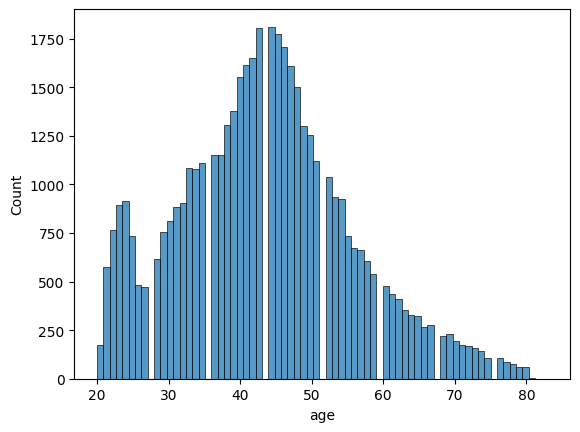

In [22]:
aux01 = df3.loc[df2['response'] == 1, 'age']
sns.histplot(aux01)

In [23]:
# gender

In [24]:
#driving_license
aux = df3[['driving_license','response']].groupby('response').sum().reset_index()
aux['driving_lic_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_lic_perc
0,0,333628,0.877283
1,1,46669,0.122717


<Axes: xlabel='region_code', ylabel='id'>

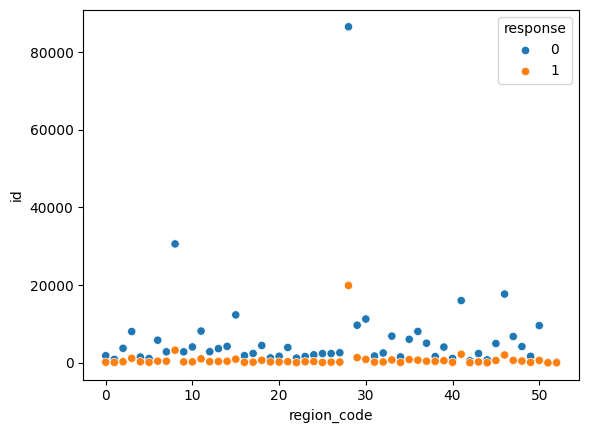

In [25]:
#region_code

aux0 = df3[['id', 'region_code', 'response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot(x='region_code',y='id',hue='response', data=aux0)


In [26]:
#previously_insured
pd.crosstab(df3['previously_insured'], df3['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [27]:
#vehicle_age
df2[['vehicle_age','response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,proportion
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


In [28]:
#vehicle_damage

<Axes: xlabel='response', ylabel='annual_premium'>

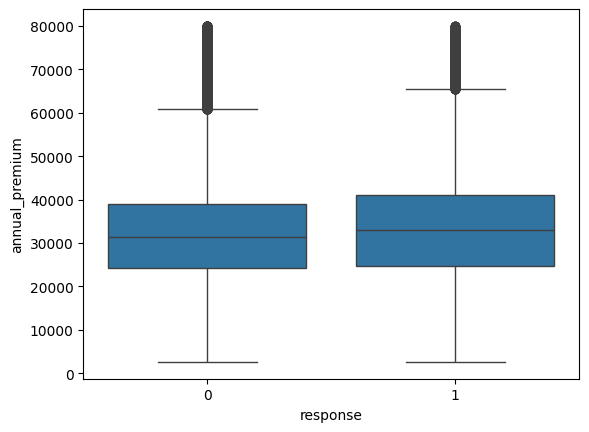

In [29]:
#annual_premium
aux = df3[df3['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

<Axes: xlabel='annual_premium', ylabel='Count'>

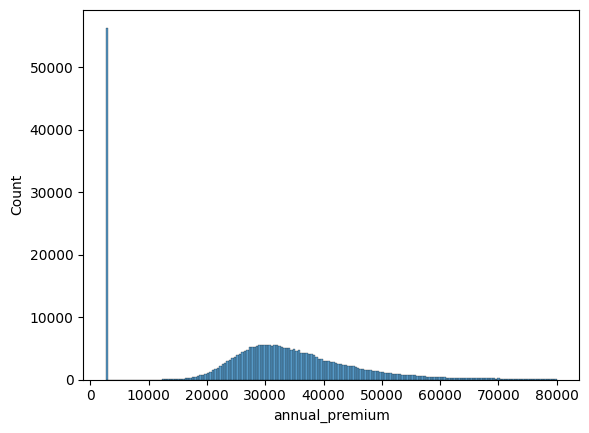

In [30]:
auxp0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(auxp0)

<Axes: xlabel='annual_premium', ylabel='Count'>

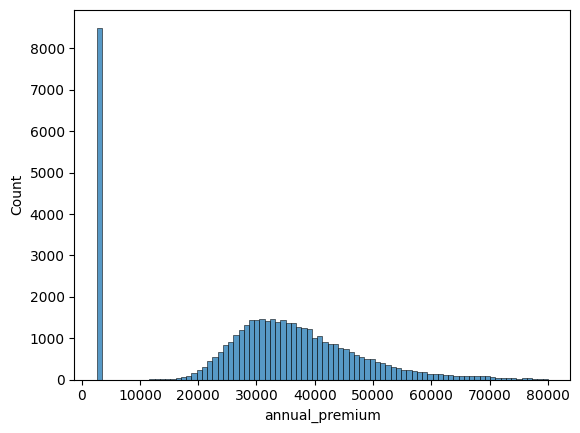

In [31]:
auxp1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(auxp1)

In [32]:
#policy_sales_channel

<Axes: xlabel='response', ylabel='vintage'>

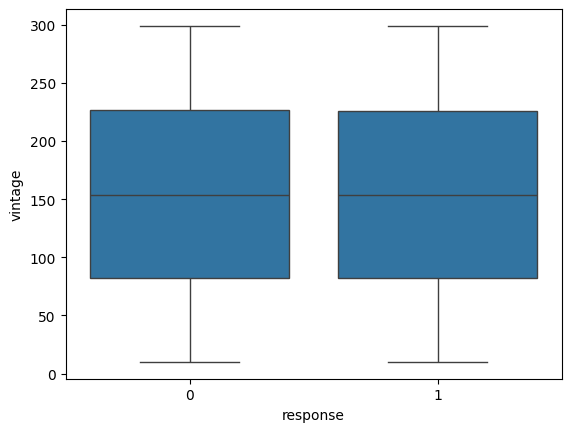

In [33]:
#vintage
#aux = df2[df2['annual_premium'] < 80000]
sns.boxplot(x='response', y='vintage', data=df3)

<Axes: xlabel='vintage', ylabel='Count'>

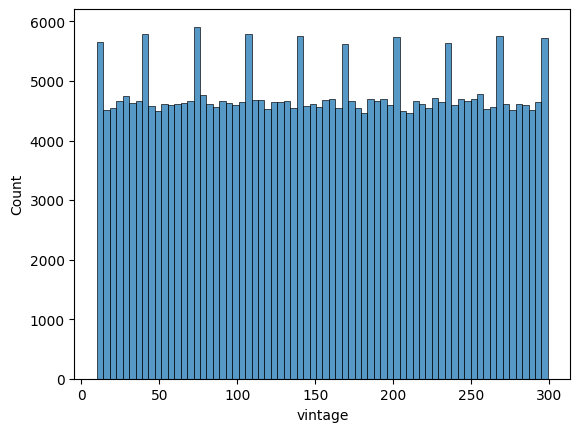

In [34]:
auxv0 = df3.loc[df3['response'] == 0, 'vintage']
sns.histplot(auxv0)

<Axes: xlabel='vintage', ylabel='Count'>

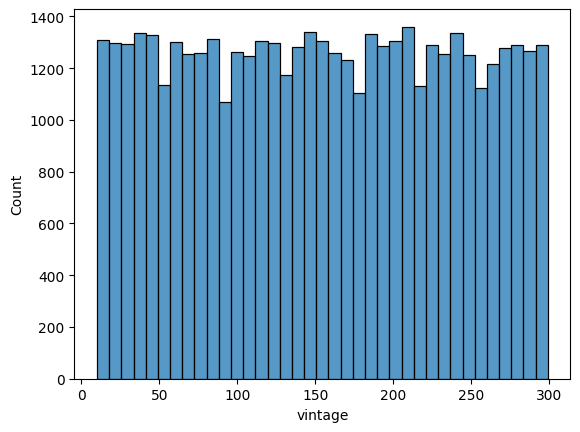

In [35]:
auxv1 = df3.loc[df2['response'] == 1, 'vintage']
sns.histplot(auxv1)

- Hipóteses:

    - Pessoas mais jovens tem menor propensão a ter um seguro de carros
    - Mulheres tem maior propensão a ter seguro de carro
    - Pessoas com habilitação tem maior propensão a ter seguro de carro
    - Pessoas que ja possuem seguro de saude tem maiores chances de adquirir o seguro de carro
    - Pessoas que possuem carros com age < 1 tem maiores chances a adquirirem seguro de carro
    - Pessoas com vintage maior, possuem maiores chances de adquirirem seguro de carro
    - Pessoas que ja tiveram carros danificados no passado, tem maior aceitação de um seguro de carro

#### Pessoas mais jovens tem menor propensão a ter um seguro de carros

In [36]:
#sns.violinplot(data=df3, x="age", y="response")

#### Mulheres tem maior propensão a ter seguro de carro

<Axes: xlabel='gender', ylabel='response'>

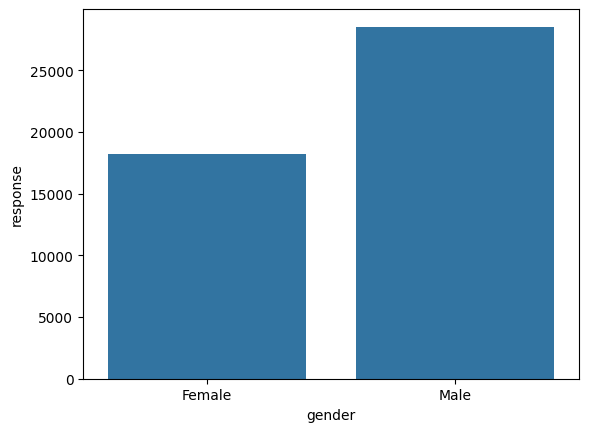

In [37]:
#df2.loc[df2['response'] == 1]

gender_response = df3[['gender', 'response']].loc[df3['response'] == 1].groupby('gender').count().reset_index()
sns.barplot(x='gender', y='response', data=gender_response)

#### Pessoas com habilitação tem maior propensão a ter seguro de carro

<Axes: xlabel='driving_license', ylabel='response'>

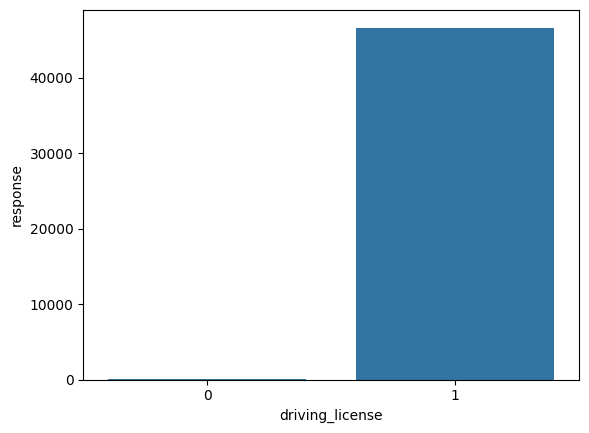

In [38]:
#df2.head()
driving_response = df3[['driving_license', 'response']].loc[df3['response'] == 1].groupby('driving_license').count().reset_index()
sns.barplot(x='driving_license', y='response', data=driving_response)

#### Pessoas que ja possuem seguro de saude tem maiores chances de adquirir o seguro de carro

<Axes: xlabel='previously_insured', ylabel='response'>

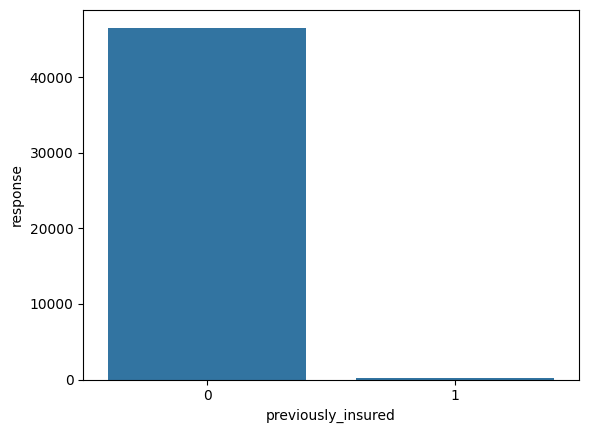

In [39]:
insured_response = df3[['previously_insured', 'response']].loc[df3['response'] == 1].groupby('previously_insured').count().reset_index()
sns.barplot(x='previously_insured', y='response', data=insured_response)

#### Pessoas que possuem carros com age < 1 tem maiores chances a adquirirem seguro de carro

<Axes: xlabel='vehicle_age', ylabel='response'>

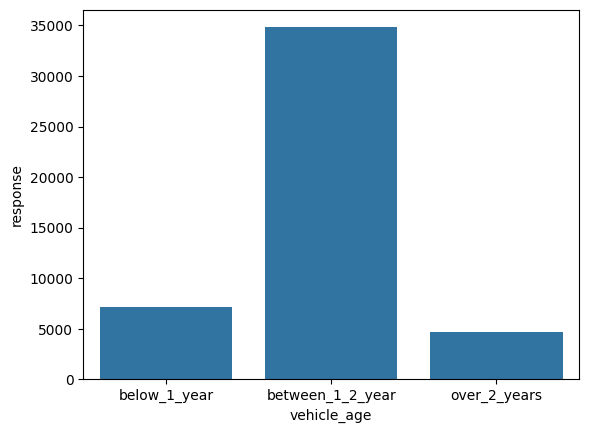

In [40]:
vehicle = df3[['vehicle_age', 'response']].loc[df3['response'] == 1].groupby('vehicle_age').count().reset_index()
sns.barplot(x='vehicle_age', y='response', data=vehicle)

#### Pessoas com vintage maior, possuem maiores chances de adquirirem seguro de carro

In [41]:
#sns.violinplot(data=df3, x="vintage", y="response")

#### Pessoas que ja tiveram carros danificados no passado, tem maior aceitação de um seguro de carro

<Axes: xlabel='vehicle_damage', ylabel='response'>

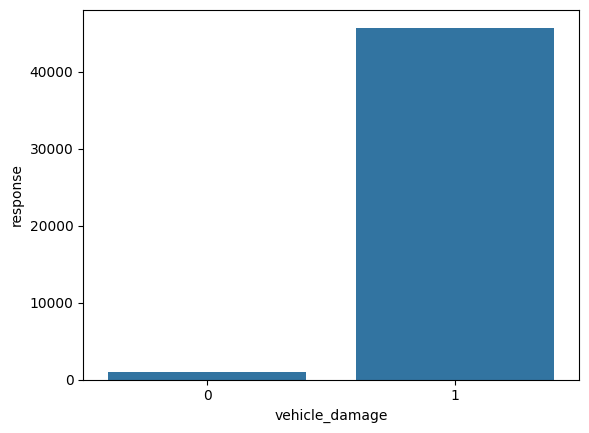

In [42]:
damage = df3[['vehicle_damage', 'response']].loc[df3['response'] == 1].groupby('vehicle_damage').count().reset_index()
sns.barplot(x='vehicle_damage', y='response', data=damage)

# 4.0 Data Preparation

In [43]:
df4 = df3.copy()

In [44]:
df_not_test, df_test = ms.train_test_split(df4, test_size=0.10, random_state=10)

df_validation, df_train = ms.train_test_split(df_not_test, test_size=0.78, random_state=10)

In [45]:
print(
f''' 
A partir do DataSet Inicial:
{round(( df_train.shape[0]/df4.shape[0])*100,0)} % é para treino
{round(( df_validation.shape[0]/df4.shape[0])*100,0)} % é para validação
{round(( df_test.shape[0]/df4.shape[0])*100,0)} % é para teste
'''
)

 
A partir do DataSet Inicial:
70.0 % é para treino
20.0 % é para validação
10.0 % é para teste



In [46]:
#df_train
y_train = df_train['response']
X_train = df_train.drop('response', axis=1)
#df_validation
y_validation = df_validation['response']
X_validation = df_validation.drop('response', axis=1)

#df_test
y_test = df_test['response']
X_test = df_test.drop('response', axis=1)




In [47]:
#X = df3.drop('response', axis=1)
#y = df3['response'].copy()
#
#x_train, x_validation, y_train, y_validation = ms.train_test_split(X,y,test_size=0.20)
#
##aux_validation = x_validation.copy()
##aux_validation['response'] = y_validation
#df4 = pd.concat([x_train,y_train],axis=1)

In [48]:
#x_validation

## 4.1 Standartization

In [49]:
#df4.head()

In [50]:
ss =  StandardScaler()

# annual_premium

X_train['annual_premium'] = ss.fit_transform( X_train[['annual_premium']].values )
pickle.dump(ss, open('../features/scaler_annual_premium.pkl', 'wb'))

## 4.2 Reescalling

In [51]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# Age (Por não se parecer com uma normal)
X_train['age'] = mms_age.fit_transform(X_train[['age']].values)
pickle.dump(mms_age, open('../features/age_reescaling.pkl', 'wb')  )

# vintage
X_train['vintage'] = mms_vintage.fit_transform(X_train[['vintage']].values)
pickle.dump(mms_vintage, open('../features/vintage_reescaling.pkl', 'wb')  )

## 4.3 Encoder

In [52]:
# gender
list_gender = {'Male':1,'Female':0}
X_train['gender'] = X_train['gender'].map(list_gender)



# region_code
fe_region_code = X_train.groupby('region_code').size()/len(X_train)
X_train.loc[:,'region_code'] = X_train['region_code'].map(fe_region_code)
pickle.dump(fe_region_code, open('../features/encoder_region_coder.pkl', 'wb'))

## vehicle_age
X_train = pd.get_dummies(X_train, prefix='vehicle_age',columns=['vehicle_age'])

## policy_sales_channel
fe_policy_sales_channel = X_train.groupby('policy_sales_channel').size()/len(X_train)
X_train.loc[:,'policy_sales_channel'] = X_train['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../features/encoder_sales_channel.pkl', 'wb'))

In [53]:
X_train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
33417,33418,0,0.353846,1,0.032036,1,0,-0.286753,0.209554,0.304498,False,True,False
200971,200972,0,0.015385,1,0.278789,1,0,-1.611033,0.002762,0.024221,True,False,False
210661,210662,0,0.076923,1,0.020304,1,0,0.052275,0.010013,0.851211,True,False,False
304782,304783,1,0.384615,1,0.032036,1,0,-0.168304,0.209554,0.290657,False,True,False
72193,72194,1,0.400000,1,0.023118,0,1,0.184276,0.194506,0.979239,False,True,False


## 4.4 Validation Preparation


In [54]:
#gender
list_gender = {'Male':1,'Female':0}
X_validation['gender'] = X_validation['gender'].map(list_gender)

#X_validation.loc[:,'gender'] = X_validation.loc[:,'gender'].map(target_encoder_gender)

# region_code
testando = pickle.load( open( '../features/encoder_region_coder.pkl', 'rb') )
X_validation.loc[:,'region_code'] = X_validation['region_code'].map(testando)


#X_validation.loc[:,'region_code'] = X_validation.loc[:,'region_code'].map(target_encode_region_code)

#vehicle_age
X_validation = pd.get_dummies(X_validation, prefix='vehicle_age',columns=['vehicle_age'])

#X_validation = pd.get_dummies(X_validation, prefix='vehicle_age', columns=['vehicle_age'])

#policy_sales_chanel
X_validation.loc[:,'policy_sales_channel'] = X_validation['policy_sales_channel'].map(fe_policy_sales_channel)

#X_validation.loc[:,'policy_sales_channel'] = X_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# age
X_validation.loc[:,'age'] = mms_age.transform(X_validation[['age']].values)

# vintage
X_validation.loc[:,'vintage'] = mms_vintage.transform(X_validation[['vintage']].values)

#annual_premium
X_validation.loc[:,'annual_premium'] = ss.transform(X_validation[['annual_premium']].values)

# fill na
X_validation = X_validation.fillna(0)


/tmp/ipykernel_225599/4185098374.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.24615385 0.12307692 0.21538462 ... 0.64615385 0.         0.38461538]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_validation.loc[:,'age'] = mms_age.transform(X_validation[['age']].values)
/tmp/ipykernel_225599/4185098374.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.84775087 0.64013841 0.96539792 ... 0.76124567 0.80622837 0.71626298]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_validation.loc[:,'vintage'] = mms_vintage.transform(X_validation[['vintage']].values)


## 4.5 Test Preparation


In [55]:
#gender
list_gender = {'Male':1,'Female':0}
X_test['gender'] = X_test['gender'].map(list_gender)

#X_validation.loc[:,'gender'] = X_validation.loc[:,'gender'].map(target_encoder_gender)

# region_code
testando = pickle.load( open( '../features/encoder_region_coder.pkl', 'rb') )
X_test.loc[:,'region_code'] = X_test['region_code'].map(testando)


#X_validation.loc[:,'region_code'] = X_validation.loc[:,'region_code'].map(target_encode_region_code)

#vehicle_age
X_test = pd.get_dummies(X_test, prefix='vehicle_age',columns=['vehicle_age'])

#X_validation = pd.get_dummies(X_validation, prefix='vehicle_age', columns=['vehicle_age'])

#policy_sales_chanel
X_test.loc[:,'policy_sales_channel'] = X_test['policy_sales_channel'].map(fe_policy_sales_channel)

#X_validation.loc[:,'policy_sales_channel'] = X_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# age
X_test.loc[:,'age'] = mms_age.transform(X_test[['age']].values)

# vintage
X_test.loc[:,'vintage'] = mms_vintage.transform(X_test[['vintage']].values)

#annual_premium
X_test.loc[:,'annual_premium'] = ss.transform(X_test[['annual_premium']].values)

# fill na
X_test = X_test.fillna(0)


/tmp/ipykernel_225599/1780135823.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.89230769 0.09230769 0.         ... 0.06153846 0.16923077 0.15384615]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:,'age'] = mms_age.transform(X_test[['age']].values)
/tmp/ipykernel_225599/1780135823.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.80968858 0.84775087 0.60899654 ... 0.35640138 0.87889273 0.96539792]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:,'vintage'] = mms_vintage.transform(X_test[['vintage']].values)


# 5.0 Feature Selection

## 5.1 Feature Importance

In [56]:
X_train

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
33417,33418,0,0.353846,1,0.032036,1,0,-0.286753,0.209554,0.304498,False,True,False
200971,200972,0,0.015385,1,0.278789,1,0,-1.611033,0.002762,0.024221,True,False,False
210661,210662,0,0.076923,1,0.020304,1,0,0.052275,0.010013,0.851211,True,False,False
304782,304783,1,0.384615,1,0.032036,1,0,-0.168304,0.209554,0.290657,False,True,False
72193,72194,1,0.400000,1,0.023118,0,1,0.184276,0.194506,0.979239,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360948,360949,0,0.015385,1,0.006859,0,1,-0.376600,0.352842,0.422145,True,False,False
109279,109280,0,0.076923,1,0.032036,1,0,-0.224126,0.352842,0.169550,True,False,False
343771,343772,0,0.000000,1,0.008204,0,1,0.383921,0.057371,0.000000,True,False,False
176024,176025,0,0.030769,1,0.020304,1,0,0.974553,0.352842,0.782007,True,False,False


In [57]:
forest = en.ExtraTreesClassifier(n_estimators=100, random_state=0,n_jobs=-1)

# data_preparation
x_train_n = X_train.drop('id', axis=1)
y_train_n = y_train.values
forest.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_jobs=-1, random_state=0)

importance rank
                        feature  importance
0                       vintage    0.272349
0                annual_premium    0.243720
0                           age    0.172364
0                   region_code    0.097554
0                vehicle_damage    0.068918
0          policy_sales_channel    0.059438
0            previously_insured    0.056659
0      vehicle_age_below_1_year    0.014549
0  vehicle_age_between_1_2_year    0.006501
0                        gender    0.004652
0      vehicle_age_over_2_years    0.002767
0               driving_license    0.000528


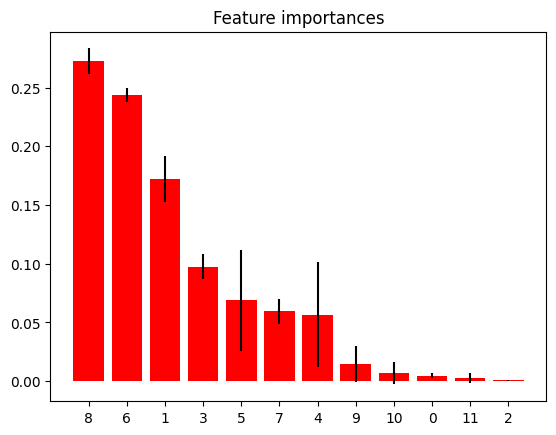

In [58]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]


print("importance rank")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature':i, 'importance':j}, index=[0] )
    df = pd.concat([df,aux], axis=0)

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 6.0 Machine Learning

In [59]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code','vehicle_damage','policy_sales_channel', 'previously_insured']

# train
#X_train = X_train[cols_selected]
X_train_model = X_train[cols_selected].fillna(0).values
y_train_model = y_train.fillna(0).values

# validation
#X_validation = X_validation[cols_selected]
X_validation_model = X_validation[cols_selected].fillna(0).values
y_validation_model = y_validation.fillna(0).values




#x_train = df4[cols_selected]
#x_val = x_validation[cols_selected]
#y_val = y_validation.copy()

## 6.1 Knn

In [60]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit(X_train_model,y_train_model)

# model prediction - Poder de GENERALIZAÇÃO
yhat_knn = knn_model.predict_proba(X_validation_model)

## 6.2 Logistic Regression

In [61]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(X_train_model,y_train_model)

# model predict
yhat_lr = lr_model.predict_proba(X_validation_model)

## 6.3 Random Forest

In [62]:
# model definition
model_rf = en.RandomForestClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
# model training
model_rf.fit(X_train_model,y_train_model)
# model predict
yhat_rf = model_rf.predict_proba(X_validation_model)

## 6.4 Extra Trees

In [63]:
# model definition
model_et = en.ExtraTreesClassifier( n_estimators= 100, random_state=42, n_jobs=-1 )

# model training
model_et.fit( X_train_model, y_train_model )

# model predict
yhat_et = model_et.predict_proba(X_validation_model)

# 7.0 Model Performance

In [64]:
from matplotlib.gridspec import GridSpec

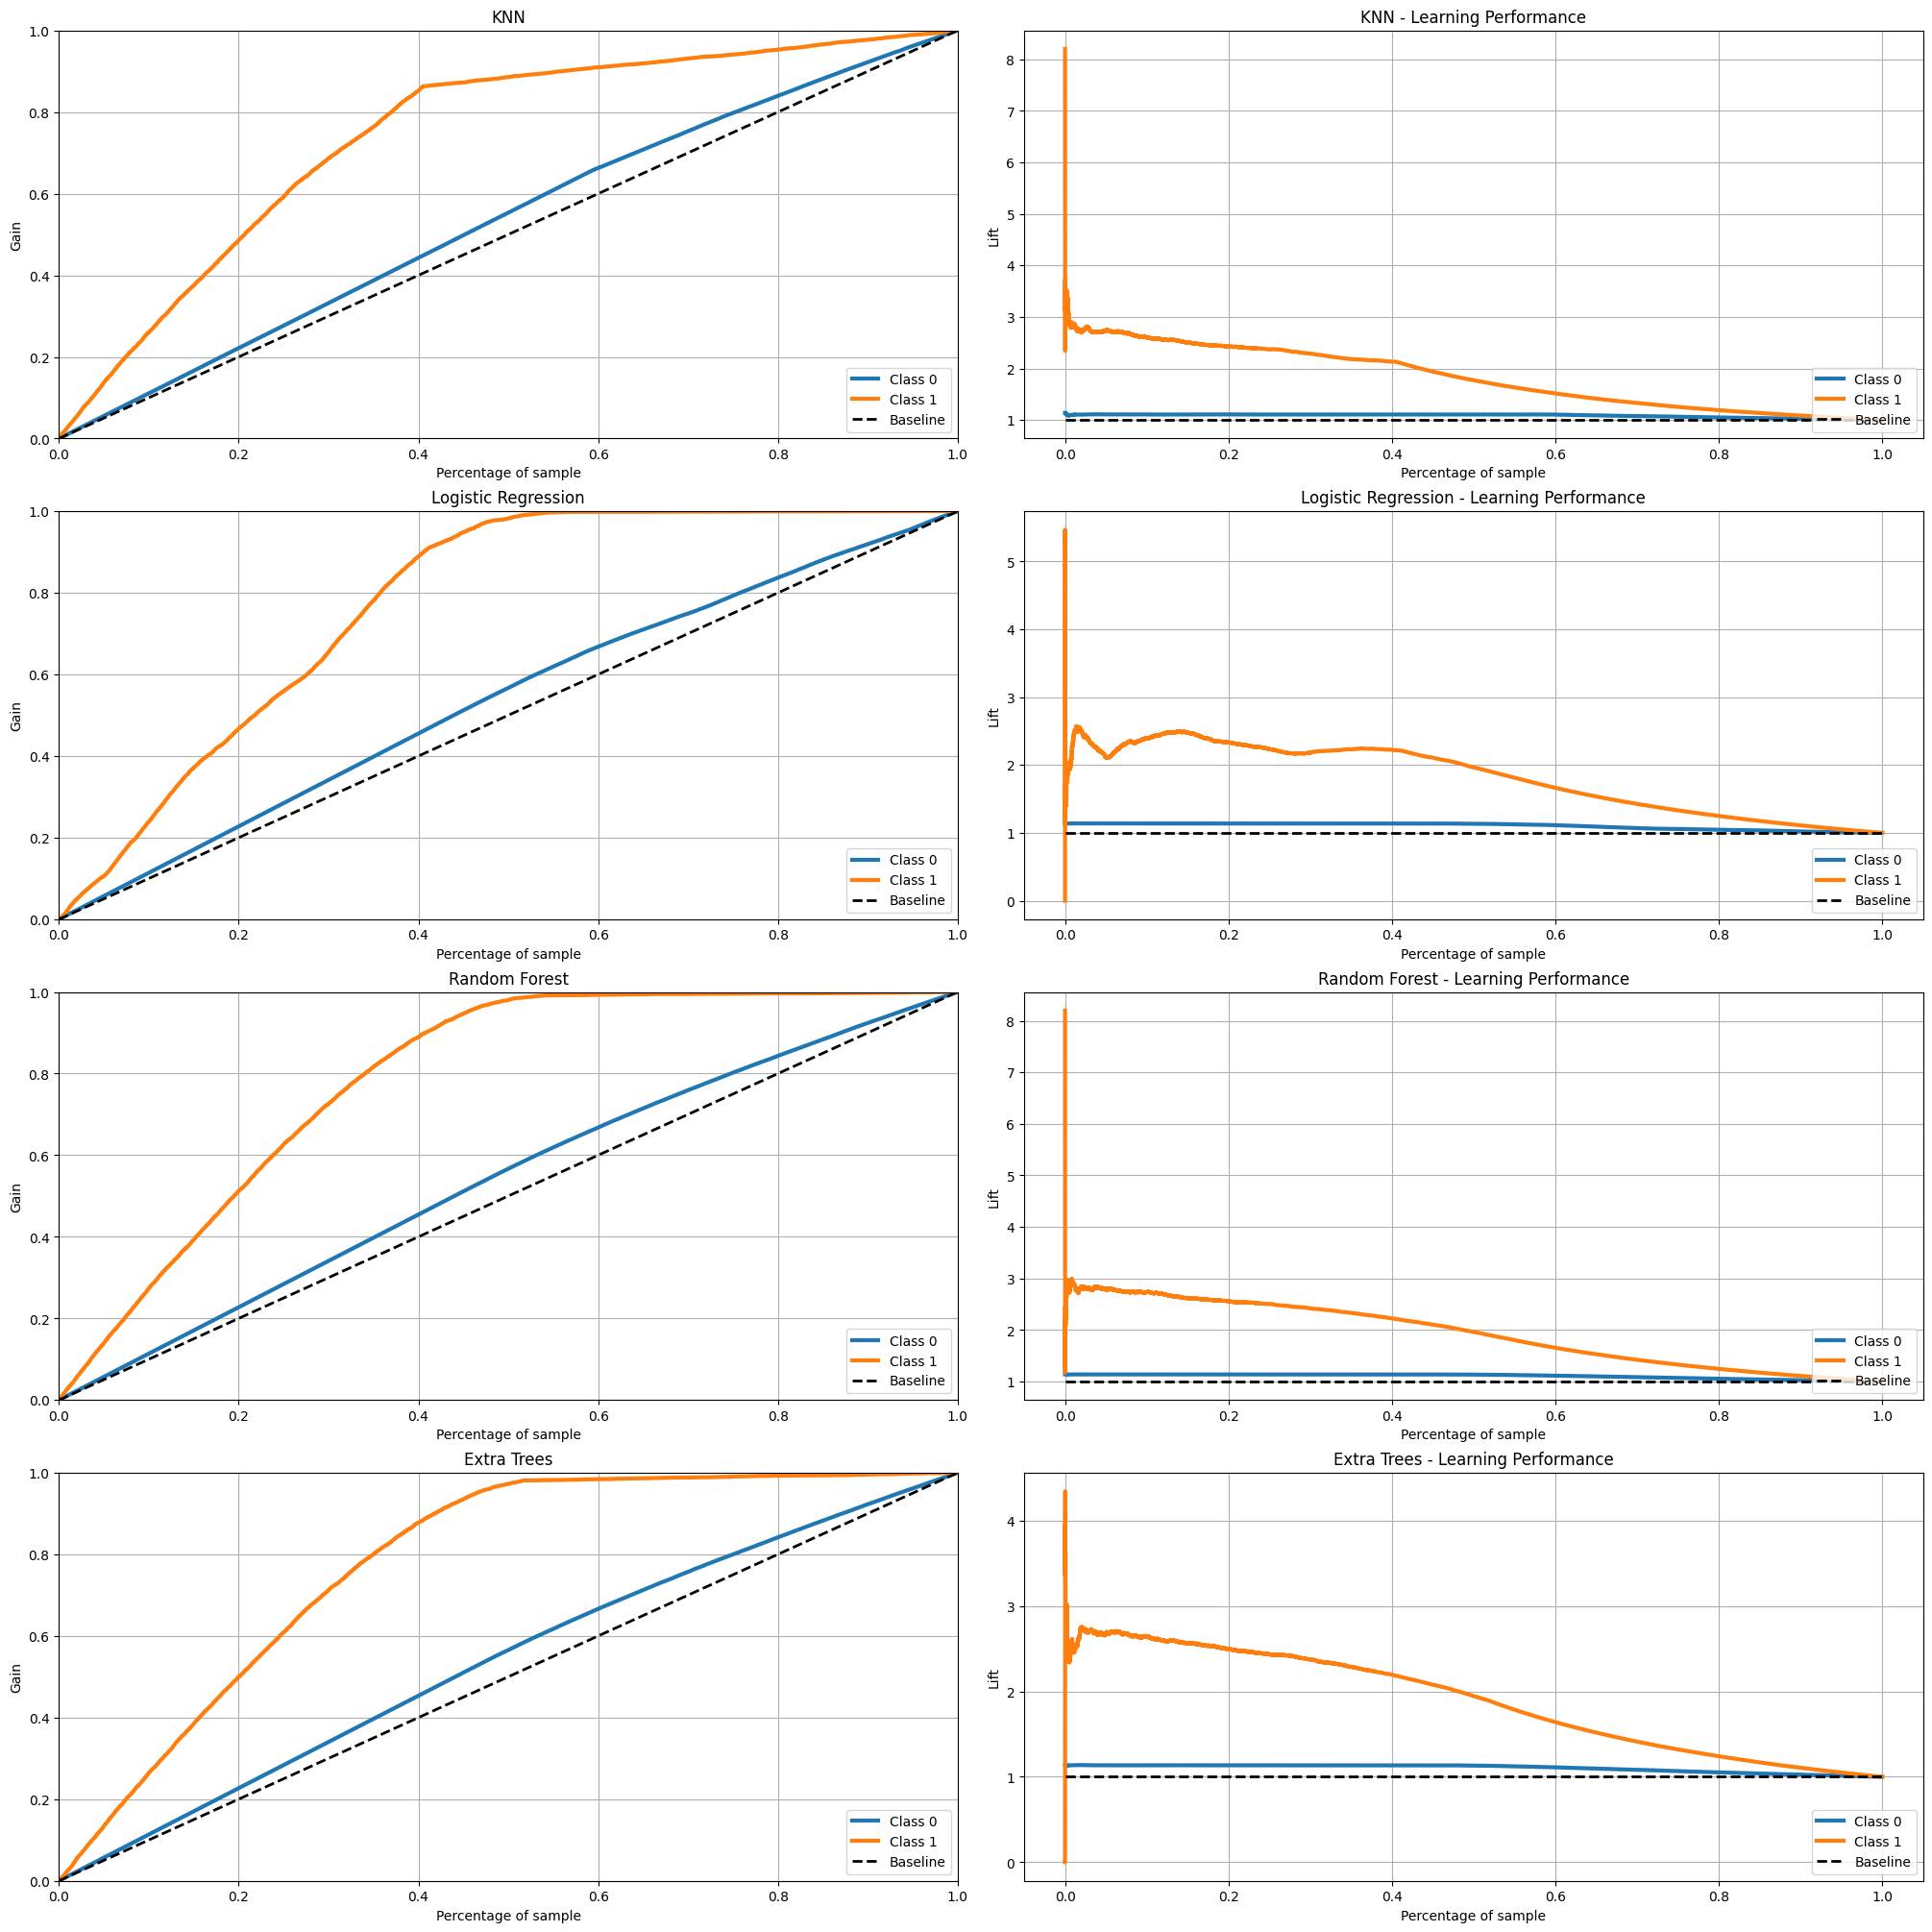

In [65]:
fig = plt.figure(figsize = (20,20), constrained_layout = True)

# create a grid for plotting
specs = GridSpec( ncols = 2, nrows = 4, figure = fig)

ax1 = fig.add_subplot( specs[0,0] )
ax2 = fig.add_subplot( specs[0,1] )

ax3 = fig.add_subplot( specs[1,0] )
ax4 = fig.add_subplot( specs[1,1] )

ax5 = fig.add_subplot( specs[2,0] )
ax6 = fig.add_subplot( specs[2,1] )

ax7 = fig.add_subplot( specs[3,0] )
ax8 = fig.add_subplot( specs[3,1] )



skplt.metrics.plot_cumulative_gain(y_validation_model,yhat_knn, title='KNN', ax=ax1)
skplt.metrics.plot_lift_curve( y_validation_model, yhat_knn, title = 'KNN - Learning Performance', ax = ax2 );

skplt.metrics.plot_cumulative_gain(y_validation_model,yhat_lr, title='Logistic Regression', ax=ax3)
skplt.metrics.plot_lift_curve( y_validation_model, yhat_lr, title = 'Logistic Regression - Learning Performance', ax = ax4 );

skplt.metrics.plot_cumulative_gain(y_validation_model,yhat_rf, title='Random Forest', ax=ax5 )
skplt.metrics.plot_lift_curve( y_validation_model, yhat_rf, title = 'Random Forest - Learning Performance', ax = ax6 );

skplt.metrics.plot_cumulative_gain(y_validation_model,yhat_et,title='Extra Trees', ax=ax7)
skplt.metrics.plot_lift_curve( y_validation_model, yhat_et, title = 'Extra Trees - Learning Performance', ax = ax8 );




In [66]:
list_proba = [yhat_knn, yhat_lr, yhat_rf,yhat_et]
list_alg = ['KNN', 'Linear Regression', 'Random Forest', 'Extra Trees']

df_precision = pd.DataFrame()
df_recall = pd.DataFrame()
df_precision['Model'] = list_alg
df_recall['Model'] = list_alg

a, b = check_performance(list_proba, X_validation, y_validation,20000) 
df_precision['precision_at_20000'], df_recall['recall_at_20000'] = check_performance(list_proba, X_validation, y_validation,20000)
df_precision['precision_at_40000'], df_recall['recall_at_40000'] = check_performance(list_proba, X_validation, y_validation,40000)


In [67]:
#teste = pd.concat([df_precision,df_recall], axis=1)
df_analysis = df_precision.merge(df_recall, how='inner', on='Model')
df_analysis = df_analysis.sort_values( ['recall_at_20000', 'recall_at_40000'], 
                                    ascending = False )
df_analysis

,Model,precision_at_20000,precision_at_40000,recall_at_20000,recall_at_40000
2,Random Forest,0.301935,0.227719,0.656270,0.989894
3,Extra Trees,0.295835,0.225769,0.643012,0.981417
0,KNN,0.286936,0.205220,0.623669,0.892089
1,Linear Regression,0.267737,0.228569,0.581939,0.993588


#### Dado o problema de negócio, escolheremos a Random Forest para aplicar o modelo em Produção!!

# 8.0 HYPERPARAMETER FINE TUNING

In [68]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

MAX_EVAL = 5

In [69]:
## Inicialize DataFrames vazios fora do loop
#df_params_performance = pd.DataFrame()
#df_precision = pd.DataFrame()
#df_recall = pd.DataFrame()
#parameters_list = []
#
#
#prec_20000 = pd.DataFrame()
#rec_20000 = pd.DataFrame()
#
#prec_40000 = pd.DataFrame()
#rec_40000 = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: rd.sample(v, 1)[0] for k, v in random_grid.items()}
#    parameters_list.append(str(hp))
#    print(hp)
#    
#    model_rf_tun = en.RandomForestClassifier(n_estimators=hp['n_estimators'],
#                                             max_features=hp['max_features'],
#                                             max_depth=hp['max_depth'],
#                                             min_samples_split=hp['min_samples_split'],
#                                             min_samples_leaf=hp['min_samples_leaf'],
#                                             bootstrap=hp['bootstrap'], random_state=42)
#    
#    model_rf_tun.fit(X_train_model, y_train_model)
#    # model predict
#    yhat_rf_tun = model_rf_tun.predict_proba(X_validation_model)
#    
#    lista_proba = [yhat_rf_tun]
#
#    result_20000 = check_performance(lista_proba, X_validation, y_validation, 20000)
#    result_40000 = check_performance(lista_proba, X_validation, y_validation, 40000)
#
#    # Append results to the DataFrames
#    prec_20000 = pd.concat([prec_20000, result_20000[0]], ignore_index=True)
#    rec_20000 = pd.concat([rec_20000, result_20000[1]], ignore_index=True)
#
#    prec_40000 = pd.concat([prec_40000, result_40000[0]], ignore_index=True)
#    rec_40000 = pd.concat([rec_40000, result_40000[1]], ignore_index=True)
#
#    prec_20000 = prec_20000.reset_index(drop=True)
#    rec_20000 = rec_20000.reset_index(drop=True)
#
#    prec_40000 = prec_40000.reset_index(drop=True)
#    rec_40000 = rec_40000.reset_index(drop=True)
#
#df_params_performance = pd.DataFrame(parameters_list, columns=['parameters'])
#
#df_params_performance = pd.concat([df_params_performance, prec_20000, rec_20000, prec_40000, rec_40000], axis=1)
#
#df_params_performance.columns = ['parameters', 'precision_at_20000', 'recall_at_20000', 'precision_at_40000',
#                                 'recall_at_40000']
#
#import warnings
#warnings.filterwarnings("ignore")

In [70]:
#df_params_performance.sort_values( ['recall_at_20000', 'recall_at_40000'], 
#                                    ascending = False )

# Avaliação de Performance e Interpretação

## Performance de Aprendizado

In [71]:
melhores_parametros = {'n_estimators': 322, 'max_features': 'sqrt', 'max_depth': 20, 
                       'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': False}

forest_tunned = en.RandomForestClassifier(n_estimators=melhores_parametros['n_estimators'],
                                                max_features=melhores_parametros['max_features'],
                                                max_depth=melhores_parametros['max_depth'],
                                                min_samples_split=melhores_parametros['min_samples_split'],
                                                min_samples_leaf=melhores_parametros['min_samples_leaf'],
                                                bootstrap=melhores_parametros['bootstrap'], random_state=42 )

# model training
forest_tunned.fit( X_train_model, y_train_model )

#predict
yhat_tunned = forest_tunned.predict_proba(X_validation_model)

Recall at 20000: 0.7018
Recall at 40000: 0.9928
Precision at 20000: 0.3229
Precision at 40000: 0.2284


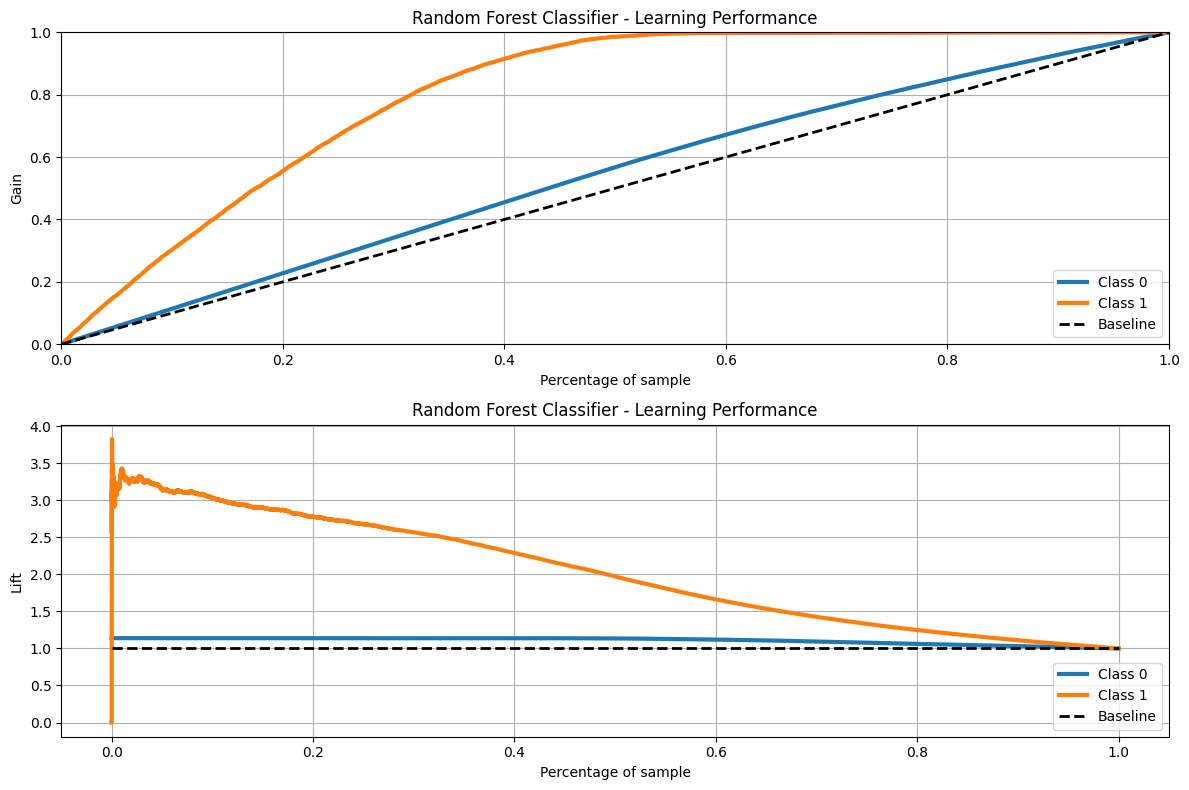

In [72]:
# Avaliação
list_prob = [yhat_tunned]

# Obter os valores de recall e precision
recall_at_20000 = check_performance(list_prob, X_validation, y_validation, 20000)[1]['recall'].iloc[0]
recall_at_40000 = check_performance(list_prob, X_validation, y_validation, 40000)[1]['recall'].iloc[0]

precision_at_20000 = check_performance(list_prob, X_validation, y_validation, 20000)[0]['precision'].iloc[0]
precision_at_40000 = check_performance(list_prob, X_validation, y_validation, 40000)[0]['precision'].iloc[0]

print('Recall at 20000: {:.4f}'.format(recall_at_20000))
print('Recall at 40000: {:.4f}'.format(recall_at_40000))

print('Precision at 20000: {:.4f}'.format(precision_at_20000))
print('Precision at 40000: {:.4f}'.format(precision_at_40000))

# Prepare figure
fig = plt.figure(figsize=(12, 8), tight_layout=True)

# Create subplots
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot cumulative gain
skplt.metrics.plot_cumulative_gain(y_validation_model, yhat_tunned,
                                    title='Random Forest Classifier - Learning Performance', ax=ax1)

# Plot lift curve
skplt.metrics.plot_lift_curve(y_validation_model, yhat_tunned,
                                title='Random Forest Classifier - Learning Performance', ax=ax2)

# Mostrar os gráficos
plt.show()


In [73]:
# concatenate X_train with X_validation to train final model
X_train_total = np.concatenate( (X_train_model, X_validation_model), axis = 0)

# concatenate Y_train with Y_validation to train final model
y_train_total = np.concatenate( (y_train_model, y_validation_model), axis = 0)

# train final model
forest_tunned.fit(X_train_total,y_train_total)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=322, random_state=42)

In [74]:
# # Save the Random trained model
with open( '../models/model_health_insurance.pkl', 'wb' ) as file:
    pickle.dump( forest_tunned, file )

## Generalization Performance

- Nesse tópico, utilizaremos o DataFrame que separamos la no começo da preparação de dados (X_test). Desse modo conseguiremos ver como o modelo performa simulando um ambiente de produção.

In [75]:
health_insurance = pickle.load(open('../models/model_health_insurance.pkl', 'rb'))
#X_test = X_test[ cols_selected ]


X_test_model = X_test[ cols_selected ].fillna(0).values

y_test_model = y_test.fillna(0).values

yhat_model_health = health_insurance.predict_proba(X_test_model)

In [76]:
# calculate equivalent k (as explained above)
equivalent_k = int( (20000 / df_production.shape[0]) * df_test.shape[0] )
equivalent_k

5999

In [77]:
X_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
80516,80517,1,0.892308,1,0.026807,0,1,0.293787,0.003214,0.809689,False,True,False
296329,296330,0,0.092308,1,0.278789,0,1,1.127488,0.209554,0.847751,True,False,False
300975,300976,0,0.000000,1,0.011438,1,0,-0.023270,0.057371,0.608997,True,False,False
316528,316529,0,0.046154,1,0.024176,1,0,0.437206,0.352842,0.809689,True,False,False
48123,48124,0,0.061538,1,0.016487,1,0,-0.351514,0.352842,0.193772,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309760,309761,1,0.692308,1,0.008331,0,1,0.318987,0.209554,0.491349,False,True,False
267455,267456,0,0.215385,1,0.004313,1,0,0.085952,0.001428,0.249135,False,True,False
370199,370200,1,0.061538,1,0.014693,0,1,-0.408317,0.352842,0.356401,True,False,False
339619,339620,1,0.169231,1,0.278789,1,1,-0.465292,0.209554,0.878893,True,False,False


Recall at 6000: 0.4629
Recall at 12000: 0.8021
Precision at 6000: 0.3591
Precision at 12000: 0.3111


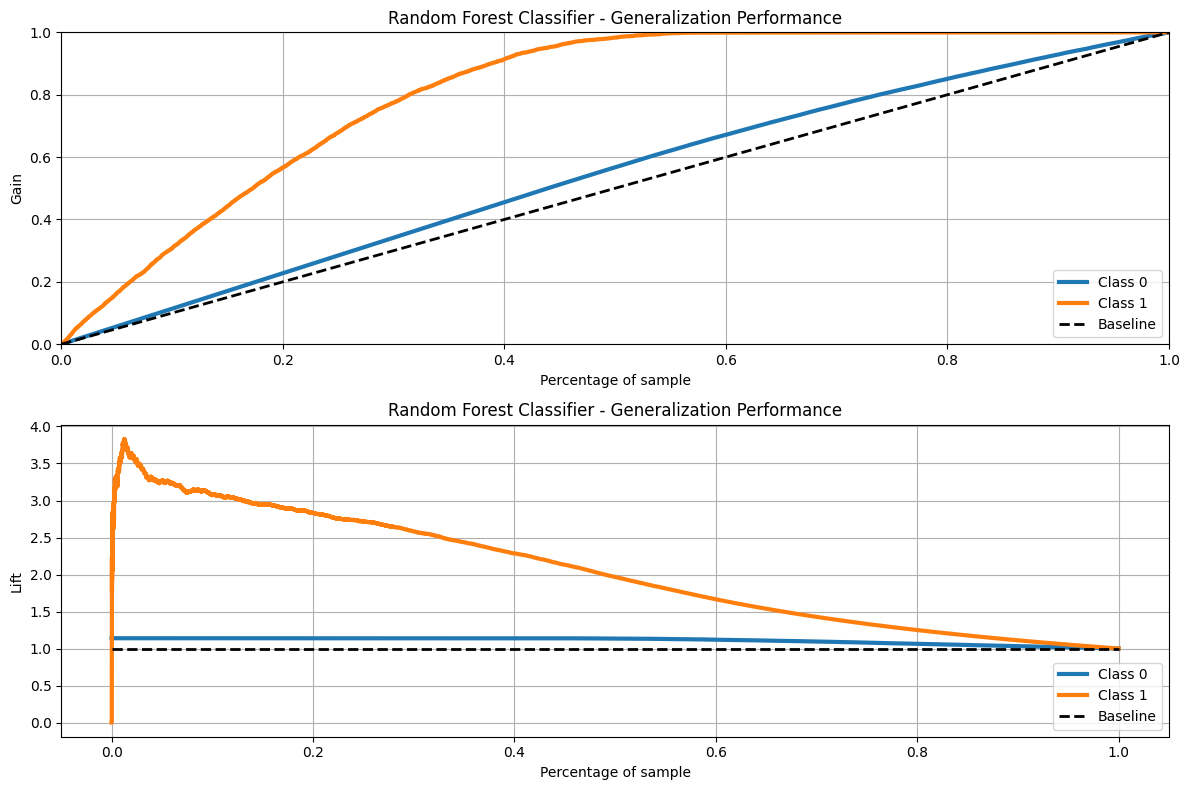

In [78]:
# Avaliação
list_prob = [yhat_model_health]

# Obter os valores de recall e precision
recall_at_6000 = check_performance(list_prob, X_test, y_test_model, 6000)[1]['recall'].iloc[0]
recall_at_12000 = check_performance(list_prob, X_test, y_test_model, 12000)[1]['recall'].iloc[0]

precision_at_6000 = check_performance(list_prob, X_test, y_test_model, 6000)[0]['precision'].iloc[0]
precision_at_12000 = check_performance(list_prob, X_test, y_test_model, 12000)[0]['precision'].iloc[0]

print('Recall at 6000: {:.4f}'.format(recall_at_6000))
print('Recall at 12000: {:.4f}'.format(recall_at_12000))

print('Precision at 6000: {:.4f}'.format(precision_at_6000))
print('Precision at 12000: {:.4f}'.format(precision_at_12000))

# Prepare figure
fig = plt.figure(figsize=(12, 8), tight_layout=True)

# Create subplots
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot cumulative gain
skplt.metrics.plot_cumulative_gain(y_test_model, yhat_model_health,
                                    title='Random Forest Classifier - Generalization Performance', ax=ax1)

# Plot lift curve
skplt.metrics.plot_lift_curve(y_test_model, yhat_model_health,
                                title='Random Forest Classifier - Generalization Performance', ax=ax2)

# Mostrar os gráficos
plt.show()


## Business Performance

### Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [79]:
twenty_k_percentage = ( 20000 / df_production.shape[0] )

twenty_k_percentage

0.15743444823161756

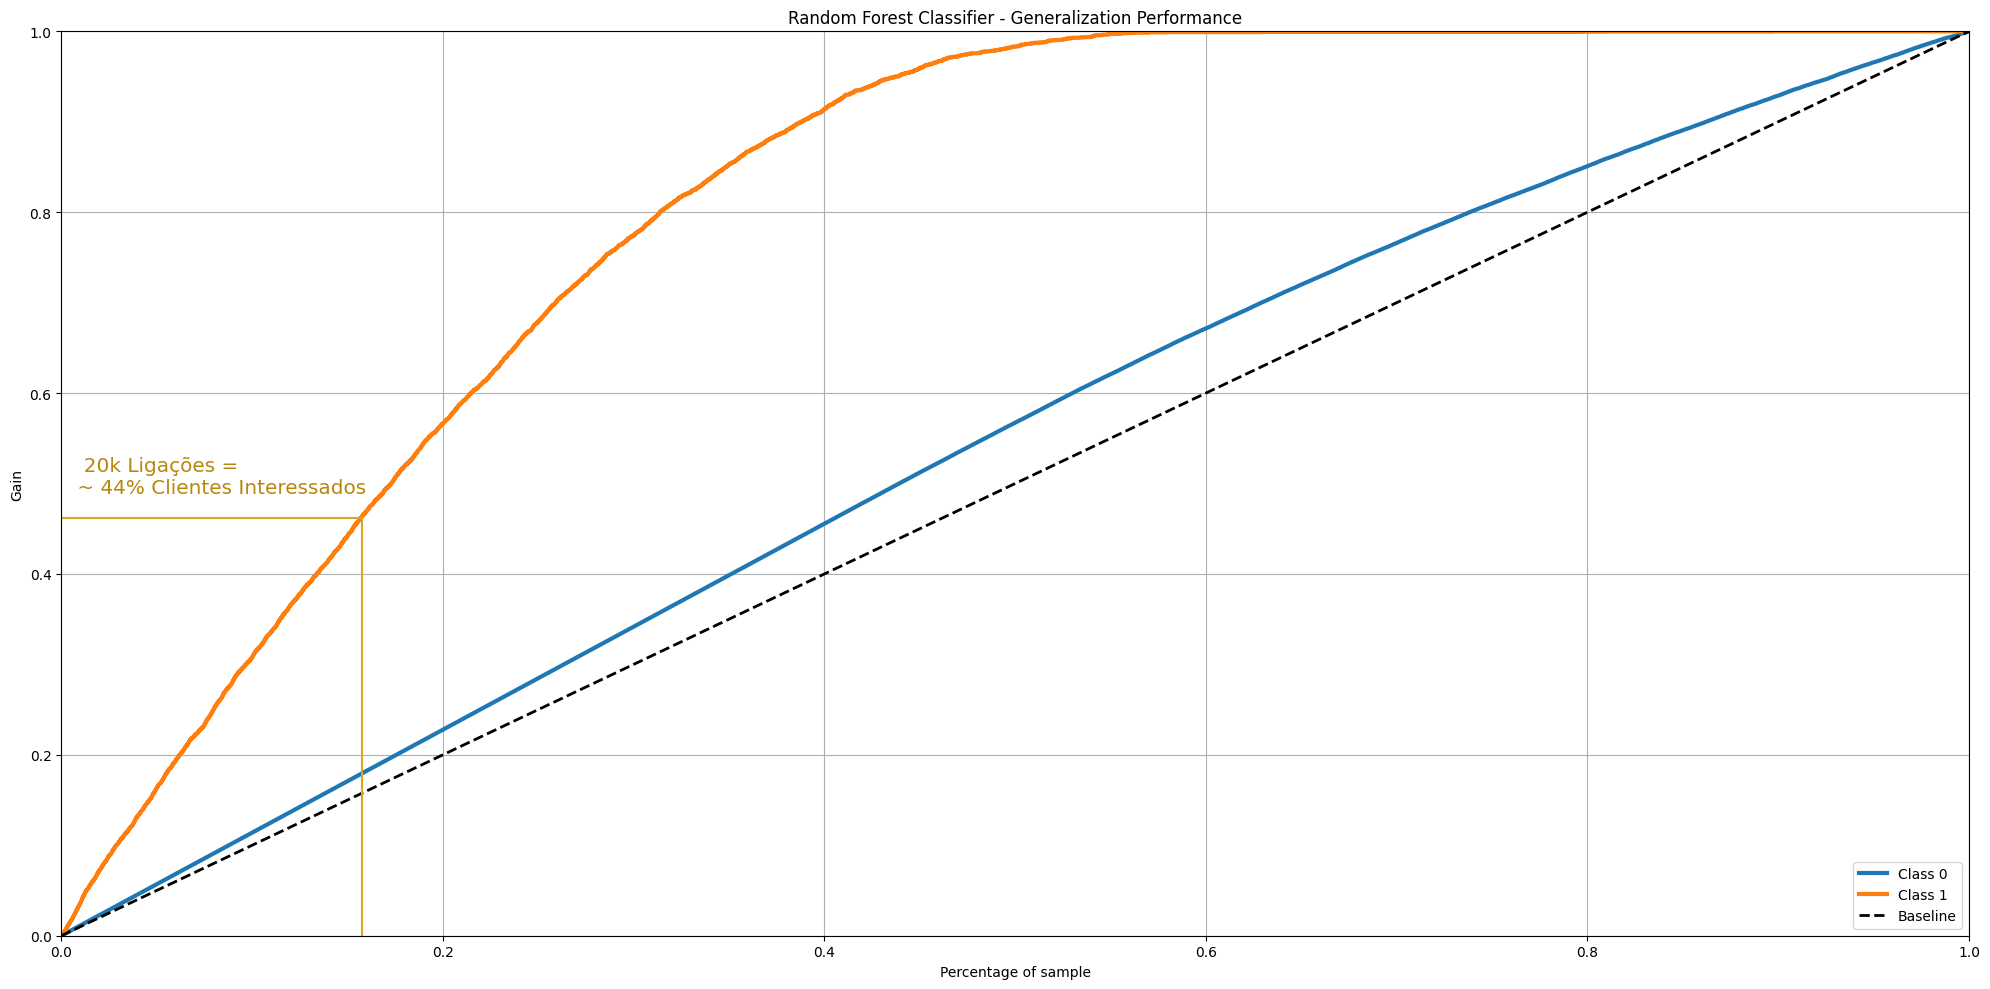

In [80]:
# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health, 
                                    title = 'Random Forest Classifier - Generalization Performance', ax = ax1 )

ax1.axvline( twenty_k_percentage, ymax = 0.462, color = 'goldenrod', label = '20k' )
ax1.axhline( 0.462 , xmax = twenty_k_percentage, color = 'goldenrod' )
plt.text( 0.005 , 0.48 + 0.01, '  20k Ligações =\n ~ 44% Clientes Interessados' , 
          color = 'darkgoldenrod', fontsize = 'x-large' );

### E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

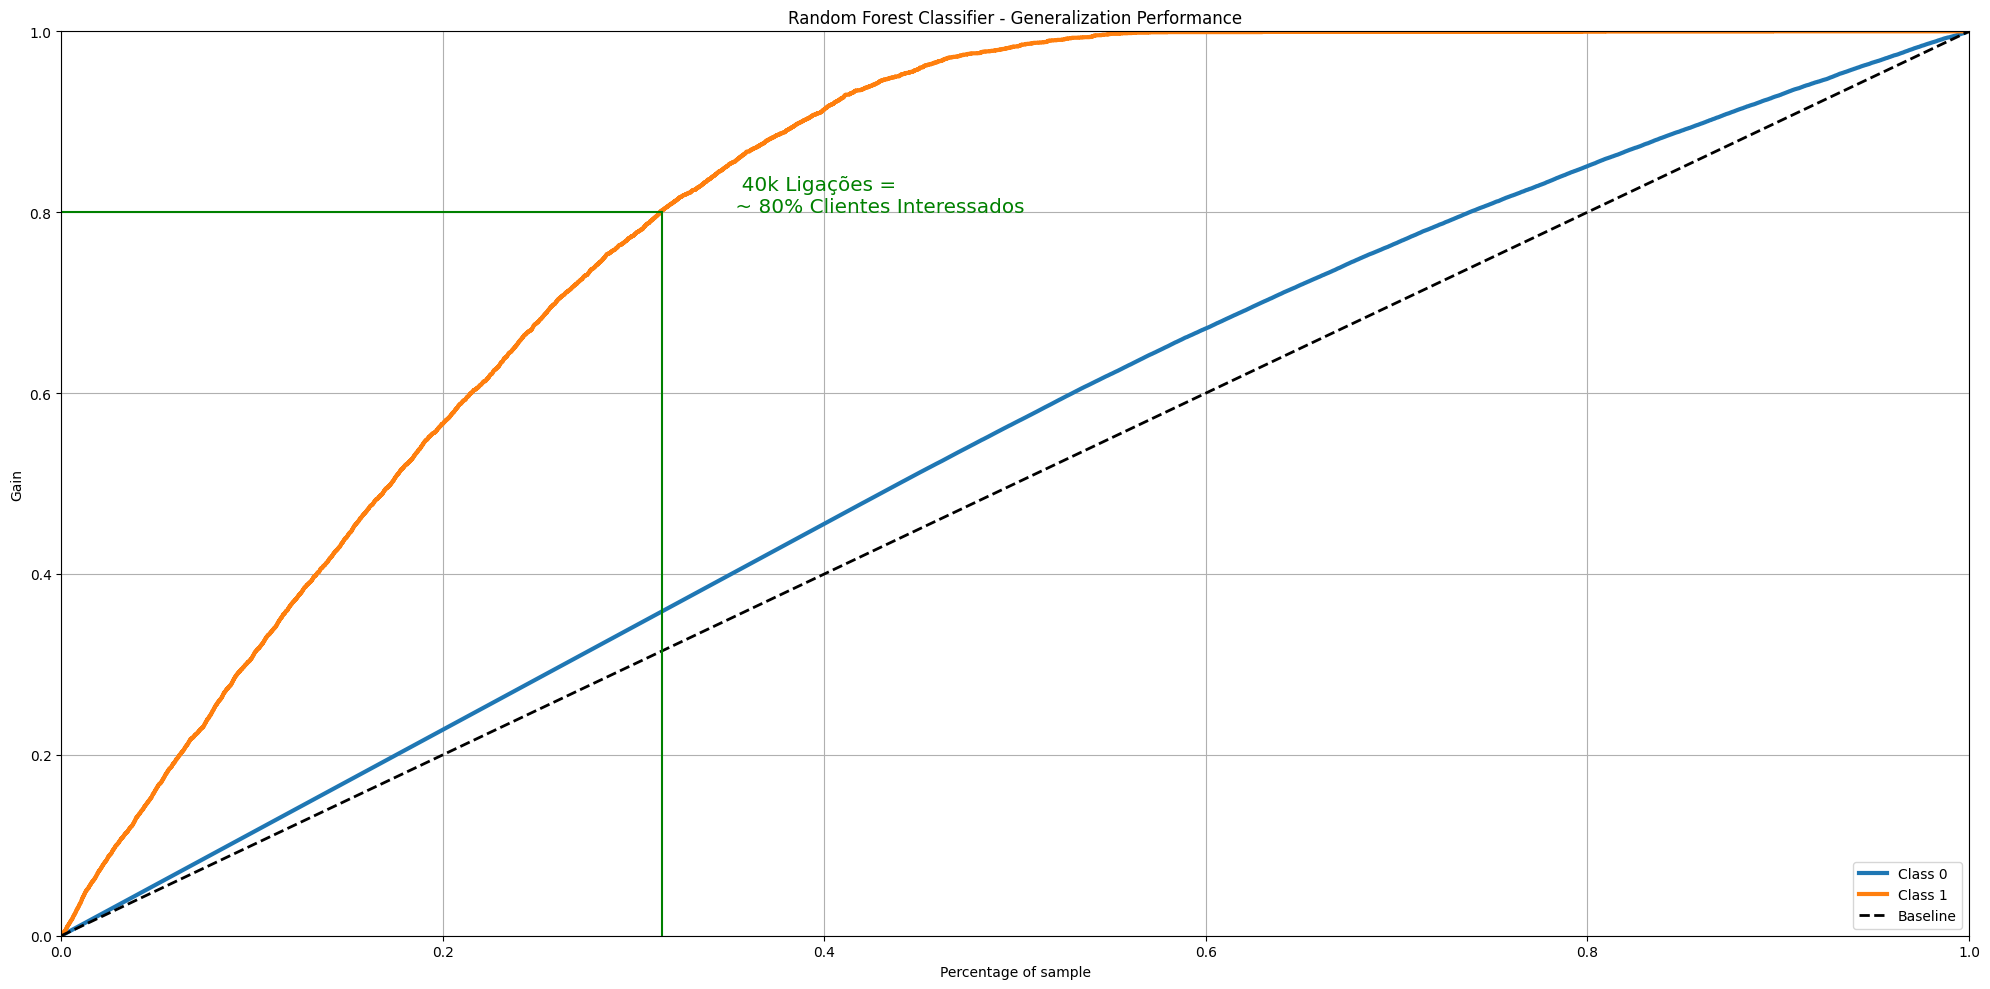

In [81]:
k_40_percentage = ( 40000 / df_production.shape[0] )

# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health, 
                                    title = 'Random Forest Classifier - Generalization Performance', ax = ax1 )

ax1.axvline( k_40_percentage, ymax = 0.8, color = 'green', label = '40k' )
ax1.axhline( 0.8, xmax = k_40_percentage, color = 'green', label = '40k' )

plt.text( 0.35 , 0.8, '  40k Ligações =\n ~ 80% Clientes Interessados' , 
          color = 'green', fontsize = 'x-large' );

### Quantas ligações o time de vendas precisa fazer para contatar 90% dos clientes interessados em adquirir um seguro de automóvel?

In [82]:
df_production.shape

(127037, 11)

49544.43


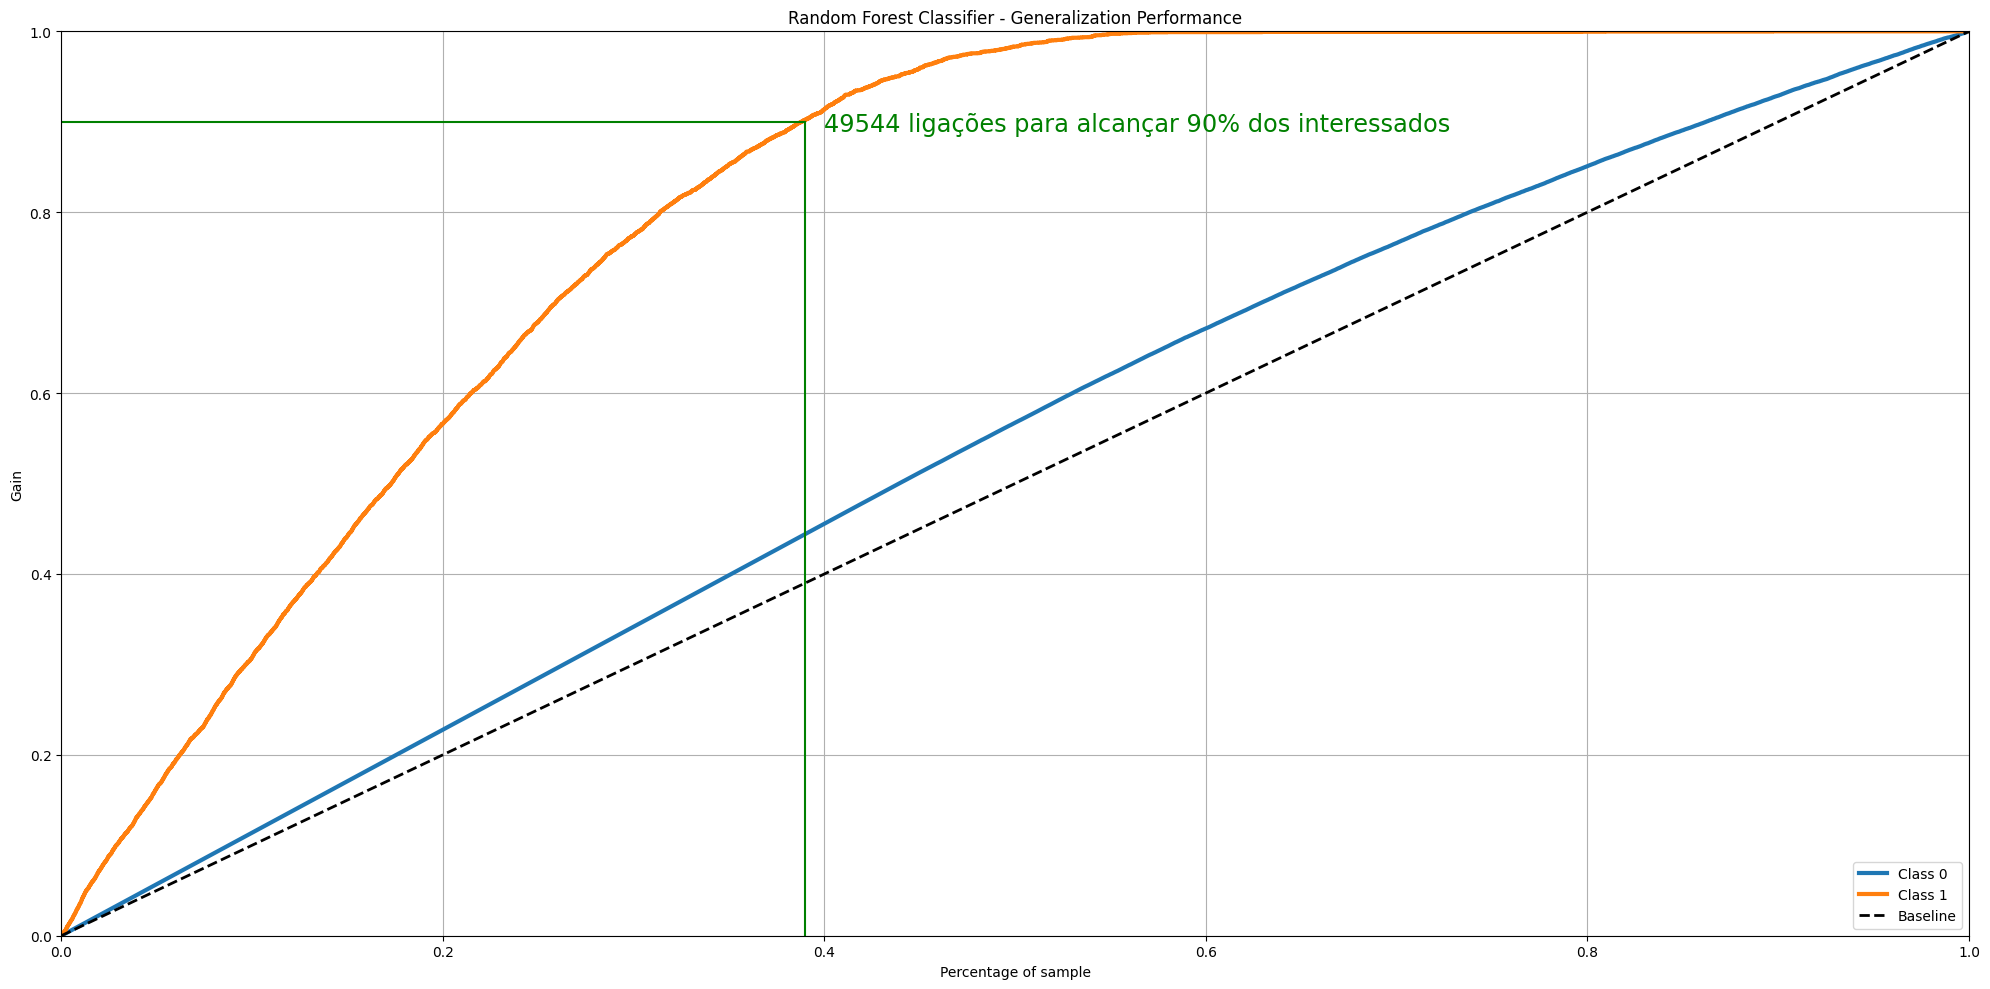

In [83]:
# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health, 
                                    title = 'Random Forest Classifier - Generalization Performance', ax = ax1 )

print(0.39*df_production.shape[0])

texto = f'49544 ligações para alcançar 90% dos interessados'

ax1.axvline( 0.39, ymax = 0.9, color = 'green' )
ax1.axhline( 0.9, xmax = 0.39, color = 'green' )

plt.text( 0.4 , 0.89, texto , color = 'green', fontsize = 'xx-large' );

# 8.0 Deploy to Production

In [108]:
pickle.dump(lr_model, open('../models/model_health_insurance.pkl', 'wb'))

In [128]:
import pandas as pd
import numpy as np
import pickle


class HealthInsurance:
    def __init__( self ):
        # carregar todos os arquivos pickle de transformação de dados
        self.home_path = 'features/'
        self.age_scaler = pickle.load( open( self.home_path + '/age_reescaling.pkl', 'rb') )
        self.region_encoder = pickle.load( open( self.home_path + 'encoder_region_coder.pkl', 'rb') )
        self.sales_channel_encoder = pickle.load( open( self.home_path + 'encoder_sales_channel.pkl', 'rb') )
        self.annual_premium_scaler = pickle.load( open( self.home_path + 'scaler_annual_premium.pkl', 'rb') )
        self.vintage_reescaling = pickle.load( open( self.home_path + 'vintage_reescaling.pkl', 'rb') )
    
    def feature_engineering(self, df2):
        # vehicle_damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        return df2
    
    def data_preparation( self, df4 ):
        # anual premium - StandarScaler
        df4['annual_premium'] = self.annual_premium_scaler.transform( df4[['annual_premium']].values )

        # Age - MinMaxScaler
        df4['age'] = self.age_scaler.transform( df4[['age']].values )

        # Vintage - MinMaxScaler
        df4['vintage'] = self.vintage_scaler.transform( df4[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df4.loc[:, 'gender'] = df4['gender'].map( self.target_encode_gender )

        # region_code - Target Encoding / Frequency Encoding
        df4.loc[:, 'region_code'] = df4['region_code'].map( self.target_encode_region_code )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map( self.fe_policy_sales_channel )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df4[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['score'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )
    
    

## 8.1 API Handler

In [91]:
import pickle
import pandas as pd
import numpy as np
import os
import sys
from flask             import Flask, request, Response
# Adding the 'healthinsurance' directory to the path
current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, 'healthinsurance'))

#path = ''
model = pickle.load(open('../models/model_health_insurance.pkl', 'rb'))

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )

def PredictCross():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        #test_raw1 = df_api_test.drop('id',axis=1)

        pipeline = HealthInsurance()

        dfa = pipeline.feature_engineering(test_raw)

        dfb = pipeline.data_preparation(dfa)

        df_response = pipeline.get_prediction(model, test_raw, dfb)


        return df_response
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )
    

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.29.24.211:5000
Press CTRL+C to quit
127.0.0.1 - - [08/Apr/2024 15:45:12] "GET / HTTP/1.1" 404 -


# 9.0 API Tester

In [84]:
import requests
import json

In [85]:
df_production.columns = ['id','gender','age','driving_license','region_code','previously_insured','vehicle_age','vehicle_damage','annual_premium','policy_sales_channel','vintage']
df_api_test = df_production.copy()

In [86]:
# select a random sample to check api
df_api_test = df_api_test.sample(10)
#df_api_test.dtypes

In [93]:
data = json.dumps( df_api_test.drop('id',axis=1).to_dict( orient='records' ) )

In [94]:
data

'[{"gender": "Female", "age": 80, "driving_license": 1, "region_code": 14.0, "previously_insured": 0, "vehicle_age": "1-2 Year", "vehicle_damage": "Yes", "annual_premium": 38378.0, "policy_sales_channel": 26.0, "vintage": 110}, {"gender": "Male", "age": 52, "driving_license": 1, "region_code": 28.0, "previously_insured": 1, "vehicle_age": "1-2 Year", "vehicle_damage": "No", "annual_premium": 47237.0, "policy_sales_channel": 26.0, "vintage": 82}, {"gender": "Female", "age": 53, "driving_license": 1, "region_code": 31.0, "previously_insured": 1, "vehicle_age": "1-2 Year", "vehicle_damage": "Yes", "annual_premium": 2630.0, "policy_sales_channel": 148.0, "vintage": 169}, {"gender": "Female", "age": 75, "driving_license": 1, "region_code": 28.0, "previously_insured": 1, "vehicle_age": "1-2 Year", "vehicle_damage": "No", "annual_premium": 34927.0, "policy_sales_channel": 26.0, "vintage": 17}, {"gender": "Female", "age": 33, "driving_license": 1, "region_code": 28.0, "previously_insured": 1, 

In [109]:
#url = 'http://127.0.0.0:5000/predict'
url = 'https://health-insurance-7s39.onrender.com/predict'

header = {'Content-type': 'application/json' } 

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [110]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [111]:
d1

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
0,0,0.923077,1,0.012484,0,1-2 Year,1,0.450470,26.0,0.346021,0.124135
1,1,0.492308,1,0.278789,1,1-2 Year,0,0.961347,26.0,0.249135,0.010023
2,0,0.507692,1,0.005162,1,1-2 Year,1,-1.611033,148.0,0.550173,0.124722
3,0,0.846154,1,0.278789,1,1-2 Year,0,0.251459,26.0,0.024221,0.009745
4,0,0.200000,1,0.278789,1,< 1 Year,1,0.591006,124.0,0.820069,0.086325
5,1,0.400000,1,0.278789,0,1-2 Year,1,1.021840,26.0,0.204152,0.168773
6,0,0.061538,1,0.023118,1,< 1 Year,0,0.604442,152.0,0.657439,0.004359
7,1,0.153846,1,0.047530,1,< 1 Year,0,-0.201463,152.0,0.930796,0.004476
8,0,0.630769,1,0.016487,0,1-2 Year,1,-0.020214,152.0,0.176471,0.076239
9,1,0.261538,1,0.278789,0,1-2 Year,1,-0.483977,124.0,0.197232,0.178931
